In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [ ]:
a = np.load("data/inverse problem/1.npz")
data = a["n_s"]
distr = a["distr"]

In [ ]:
plt.plot(data, marker=".")

In [ ]:
kernel_carbon = np.load("data/kernel_generated2/Kernel_s_Carbon-loc-isoth-N2.xlsx.npy")

In [ ]:
pore_widths = np.load("data/kernel_generated2/Size_Carbon-loc-isoth-N2.xlsx.npy")

In [ ]:
def plot():
    plt.grid()
    plt.legend()
    plt.show()


def fit(loading, kernel, alpha=0, beta=0):
    def kernel_loading(pore_dist):
            return np.multiply(
                kernel,
                pore_dist[:, np.newaxis]
            ).sum(axis=0)
    
    def sum_squares(pore_dist):
        S_tot = np.sum(pore_dist)
        w = pore_dist / S_tot
        return np.square( 
            np.subtract(
                kernel_loading(pore_dist),
                loading)).sum(axis=0) + alpha*np.sum(w*np.log(w))/len(pore_dist) + beta*np.sum(np.square(pore_dist))
    
    cons = [{
        'type': 'ineq',
        'fun': lambda x: x,
    }]
    guess = np.array([0.001 for pore in pore_widths])
    bounds = [(0, None) for pore in pore_widths]
    result = optimize.minimize(
        sum_squares,
        guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons,
        options={'ftol': 1e-04}
    )
    return result

In [ ]:
data_with_error = data * np.random.normal(loc=1, scale=0.01, size=len(data))
plt.plot(data, marker=".", label="original")
plt.plot(data_with_error, marker=".", label="with error")
plot()

## Without regularization

In [ ]:
res1 = fit(data, kernel_carbon)
res2 = fit(data_with_error, kernel_carbon)

In [ ]:
plt.plot(pore_widths, res1.x, marker=".", label="prediction")
plt.plot(pore_widths, res2.x, marker=".", label="prediction with error")
plt.plot(pore_widths, distr, marker=".", label="real")
plot()

In [ ]:
res3 = fit(data, kernel_carbon, alpha=0.01, beta=0.01)
res4 = fit(data_with_error, kernel_carbon, alpha=0.01, beta=0.01)

In [ ]:
#plt.plot(pore_widths, res3.x, marker=".", label="prediction")
plt.plot(pore_widths, res4.x, marker=".", label="prediction with error")
plt.plot(pore_widths, distr, marker=".", label="real")
plot()

In [ ]:
kernel2 = np.load("data/kernel_generated2/Kernel_s_Silica-loc-isoth1.xlsx.npy")

In [ ]:
exp_data = np.loadtxt("data/real/carbon.txt")
p_exp = np.empty(len(exp_data))
volume_exp = np.empty(len(exp_data))
for i in range(len(exp_data)):
    p_exp[i] = exp_data[i][0]
    volume_exp[i] = exp_data[i][1]
j = np.argmax(volume_exp)
volume_exp_sorb = volume_exp[:j]
p_exp_sorb = p_exp[:j]
plt.plot(p_exp_sorb, volume_exp_sorb, marker=".", label="real")
plot()

In [ ]:
kernel_p = np.load("data/kernel_generated2/Pressure_s_Carbon-loc-isoth-N2.xlsx.npy")
p_exp_sorb_interp = np.interp(kernel_p, p_exp_sorb, volume_exp_sorb)
plt.plot(kernel_p, p_exp_sorb_interp, marker=".")
plt.plot(p_exp_sorb, volume_exp_sorb, marker=".")
plot()

In [48]:
res_exp = fit(p_exp_sorb_interp, kernel_carbon, alpha=0.01, beta=0.01)

C:\Users\ivano\AppData\Local\Temp\ipykernel_8660\1021987262.py:20: RuntimeWarning: divide by zero encountered in log
  loading)).sum(axis=0) + alpha*np.sum(w*np.log(w))/len(pore_dist) + beta*np.sum(np.square(pore_dist))
C:\Users\ivano\AppData\Local\Temp\ipykernel_8660\1021987262.py:20: RuntimeWarning: invalid value encountered in multiply
  loading)).sum(axis=0) + alpha*np.sum(w*np.log(w))/len(pore_dist) + beta*np.sum(np.square(pore_dist))


In [51]:
real_distr = np.loadtxt("data/real/carbon_distr.txt", skiprows=4, unpack=True)

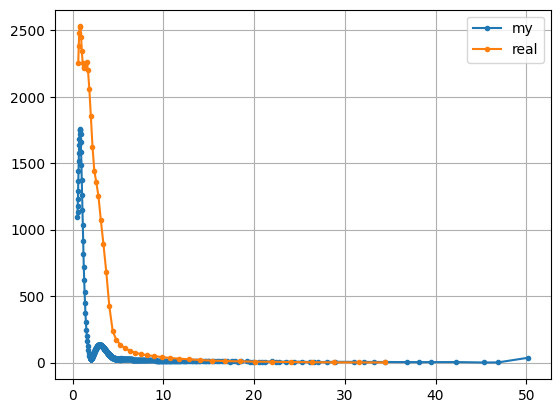

In [53]:
plt.plot(pore_widths, res_exp.x, marker=".", label="my")
plt.plot(real_distr[0], real_distr[4], marker=".", label="real")

plot()